# 구내식당 인기메뉴 예측 모델 만들기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

## 1. 데이터 가져오기

In [3]:
restaurant = pd.read_csv('./datasets/restaurant_train.csv', encoding='utf-8')

## 2. 데이터 훑어보기

In [4]:
restaurant.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [5]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


**범주형 특성 탐색**

In [6]:
restaurant['중식메뉴'].value_counts()

쌀밥/잡곡밥 (쌀:국내산) 시금치된장국  훈제오리구이  실곤약무침  무쌈/양파절임  포기김치 (김치:국내산)            2
곤드레밥*양념장 (쌀:국내산) 맑은국  돈육강정 (돈육:국내산) 사과고구마그라탕  오복지무침  배추겉절이 (김치:국내산)     2
쌀밥/잡곡밥 (쌀:국내산) 매운소고기국  유린기  코다리조림  치커리사과무침  포기김치 (김치:국내산)               2
쌀밥/잡곡밥 (쌀:국내산) 차돌된장찌개  주꾸미볶음  옥수수전  양념깻잎지  포기김치 (김치:국내산)                2
단호박영양밥 (쌀,돈육:국내산) 유부장국  새송이너비아니구이  양장피  오이무침  포기김치 (김치:국내산)             2
                                                                       ..
쌀밥/잡곡밥 (쌀:국내산) 차돌박이찌개  해물누룽지탕  돈육잡채  마늘쫑무침  포기김치 (김치:국내산)               1
쌀밥/잡곡밥 (쌀:국내산) 시래기된장국  유자청제육볶음  오꼬노미야끼계란말이  치커리무침  포기김치 (김치:국내산)        1
쌀밥/잡곡밥 (쌀:국내산) 열무된장국  동파육  셀프무쌈말이  통도라지구이  포기김치 (김치:국내산)                1
쌀밥/잡곡밥 (쌀:국내산) 쇠고기미역국  오징어볶음*소면  고기전  호박나물  포기김치 (김치:국내산)               1
쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치/요구르트 양배추샐러드*사우전D         1
Name: 중식메뉴, Length: 1198, dtype: int64

In [7]:
restaurant['석식메뉴'].value_counts()

    *                                                                    19
                                                                          4
    자기계발의날                                                                3
    자기개발의날                                                                3
쌀밥/잡곡밥 (쌀:국내산) 감자국  닭데리야끼조림  매운어묵볶음  참나물땅콩가루무침  포기김치 (김치:국내산)             2
                                                                         ..
닭갈비볶음밥 (쌀:국내산) 가쯔오장국  크림카레우동  감자만두/샐러드 *흑임자드레싱 비트무생채  포기김치 (김치:국내산)       1
쌀밥/잡곡밥 (쌀:국내산) 콩나물김치국  가자미튀김  모듬소세지구이  가지나물  열무김치 (김치:국내산)                1
쌀밥/잡곡밥 (쌀:국내산) 옛날돈까스  브로컬리크림스프  키위드레싱샐러드  고구마범벅/무피클 음료 포기김치 (김치:국내산)      1
쌀밥/잡곡밥 (쌀:국내산) 부대찌개  해물청경채볶음  메밀전  청포묵무침  포기김치 (김치:국내산)                   1
(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기                                 1
Name: 석식메뉴, Length: 1168, dtype: int64

In [8]:
#수치형 특성 탐색
restaurant.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


**수치형 특성별 히스토그램**

C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Anconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 55092 (\N{HANG

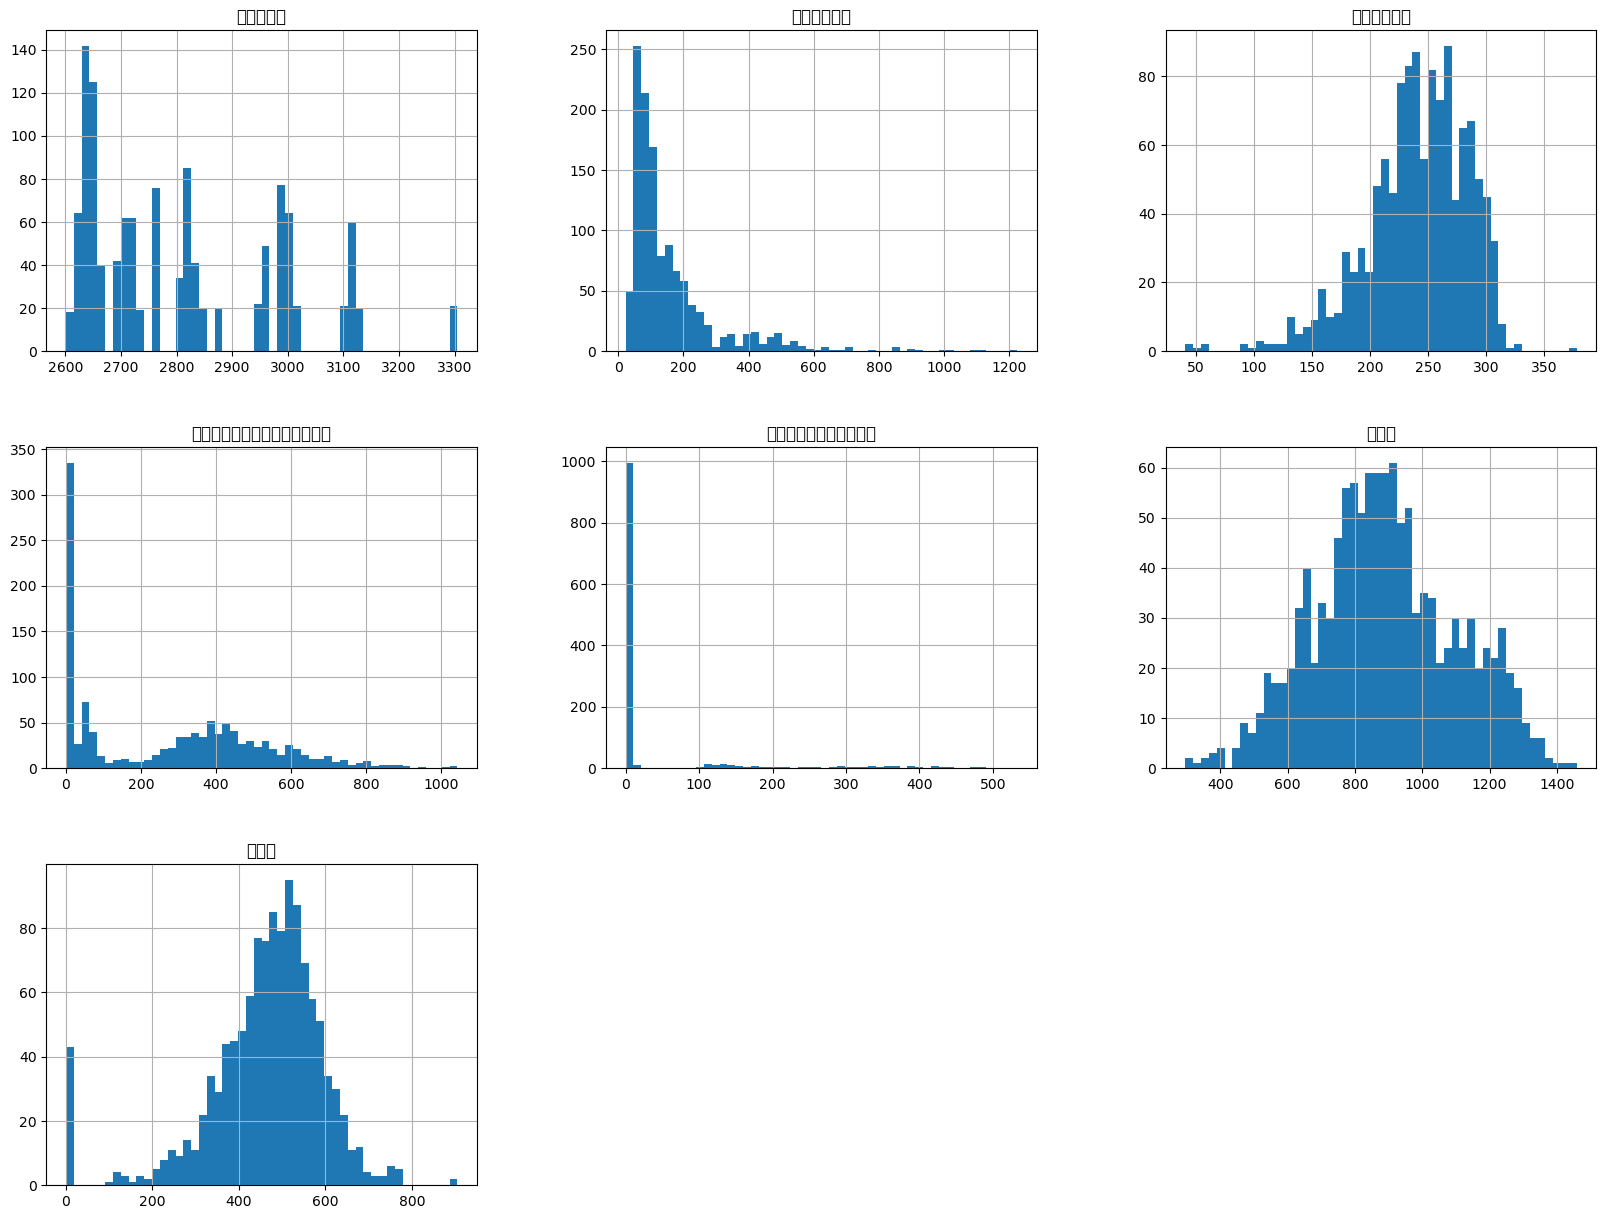

In [9]:
restaurant.hist(bins = 50, figsize = (20, 15))
plt.show()

**불필요한 열 - 조식메뉴- 삭제**

In [10]:
restaurant.drop(['조식메뉴'], axis =1, inplace = True)
restaurant.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


**일자정보를 object에서 datetime으로 변경**

In [11]:
restaurant['date'] = restaurant['일자'].astype('str')
restaurant['date'] = pd.to_datetime(restaurant['date'])

In [12]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   object        
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   중식메뉴            1205 non-null   object        
 8   석식메뉴            1205 non-null   object        
 9   중식계             1205 non-null   float64       
 10  석식계             1205 non-null   float64       
 11  date            1205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 113.1+ KB


In [13]:
#from colletions import Counter
#dict(Countr(dict_name))

In [14]:
import re
from collections import Counter
import operator

In [15]:
lunchmenu = list(restaurant['중식메뉴'])
dinnermenu = list(restaurant['석식메뉴'])
daymenu = lunchmenu + dinnermenu

for menus in daymenu:
    print(menus)

쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 (쇠고기:호주산) 계란찜  청포묵무침  요구르트  포기김치 (배추,고추가루:국내산) 
쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개  가자미튀김  모둠소세지구이  마늘쫑무침  요구르트  배추겉절이 (배추,고추가루:국내산) 
카레덮밥 (쌀,현미흑미:국내산) 팽이장국  치킨핑거 (닭고기:국내산) 쫄면야채무침  견과류조림  요구르트  포기김치 (배추,고추가루:국내산) 
쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국  주꾸미볶음  부추전  시금치나물  요구르트  포기김치 (배추,고추가루:국내산) 
쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국  돈육씨앗강정 (돼지고기:국내산) 우엉잡채  청경채무침  요구르트  포기김치 (배추,고추가루:국내산) 
쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국  훈제오리구이  도토리묵무침  쌈무/양파절임  요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕  돈육굴소스볶음  옥수수전  유채나물  요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀:국내산) 시금치국  닭감자조림 (닭고기:국내산) 연두부*양념장  콩나물무침  요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오징어숙회무침  취나물  요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀:국내산) 냉이된장국  쇠고기장조림 (쇠고기:호주산) 통도라지구이  치커리무침  요구르트  포기김치 (김치:국내산) 
낙지비빔밥 (낙지:중국산,쌀:국내산) 유부장국  고구마치즈구이  해초무침  요구르트  요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀:국내산) 대구찌개  마늘간장치킨 (닭고기:국내산) 새송이버섯볶음  돌나물무침/치킨무  요구르트  포기김치 (김치:국내산) 
쌀밥/오곡밥 (쌀:국내산) 쇠고기느타리국  갈치구이  호박꼬지&고사리&무나물  파래김*양념장  부럼/요구르트  포기김치 (김치:국내산) 
쌀밥/잡곡밥 (쌀:국내산) 콩나물

In [16]:
lunchmenu = restaurant['중식메뉴']
marks = ['(', ')', ':', ' ', '*', '/']

menu1_list = []

for menus in daymenu:   
    for mark in marks:
        menu1 = menus.replace('(', ' ')
        menu1 = menu1.replace(')', ' ')
        menu1 = menu1.replace(':', ' ')
        menu1 = menu1.replace('*', ' ')
        menu1 = menu1.replace('/', ' ')
        menu1 = menu1.replace(',', ' ')
        menu1 = menu1.replace('.', ' ')
        menu1 = menu1.replace('&', ' ')
    menu1 = re.split(r' ', menu1)
    menu1_list.extend(menu1)
    #menu1 = menu1.replace(' ', '')
print(menu1_list)

['쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '오징어찌개', '', '쇠불고기', '', '쇠고기', '호주산', '', '계란찜', '', '청포묵무침', '', '요구르트', '', '포기김치', '', '배추', '고추가루', '국내산', '', '', '쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '김치찌개', '', '가자미튀김', '', '모둠소세지구이', '', '마늘쫑무침', '', '요구르트', '', '배추겉절이', '', '배추', '고추가루', '국내산', '', '', '카레덮밥', '', '쌀', '현미흑미', '국내산', '', '팽이장국', '', '치킨핑거', '', '닭고기', '국내산', '', '쫄면야채무침', '', '견과류조림', '', '요구르트', '', '포기김치', '', '배추', '고추가루', '국내산', '', '', '쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '쇠고기무국', '', '주꾸미볶음', '', '부추전', '', '시금치나물', '', '요구르트', '', '포기김치', '', '배추', '고추가루', '국내산', '', '', '쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '떡국', '', '돈육씨앗강정', '', '돼지고기', '국내산', '', '우엉잡채', '', '청경채무침', '', '요구르트', '', '포기김치', '', '배추', '고추가루', '국내산', '', '', '쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '시래기국', '', '훈제오리구이', '', '도토리묵무침', '', '쌈무', '양파절임', '', '요구르트', '', '포기김치', '', '김치', '국내산', '', '', '쌀밥', '잡곡밥', '', '쌀', '현미흑미', '국내산', '', '꽃게탕', '', '돈육굴소스볶음', '', '옥수수전', '', '유채

In [17]:

# for r in result:
#     if r != '':
#         temp_list.append(r)
        
menu_list= [menu for menu in menu1_list if menu != '' ]
print(menu_list)

['쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '오징어찌개', '쇠불고기', '쇠고기', '호주산', '계란찜', '청포묵무침', '요구르트', '포기김치', '배추', '고추가루', '국내산', '쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이', '배추', '고추가루', '국내산', '카레덮밥', '쌀', '현미흑미', '국내산', '팽이장국', '치킨핑거', '닭고기', '국내산', '쫄면야채무침', '견과류조림', '요구르트', '포기김치', '배추', '고추가루', '국내산', '쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치', '배추', '고추가루', '국내산', '쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '떡국', '돈육씨앗강정', '돼지고기', '국내산', '우엉잡채', '청경채무침', '요구르트', '포기김치', '배추', '고추가루', '국내산', '쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '시래기국', '훈제오리구이', '도토리묵무침', '쌈무', '양파절임', '요구르트', '포기김치', '김치', '국내산', '쌀밥', '잡곡밥', '쌀', '현미흑미', '국내산', '꽃게탕', '돈육굴소스볶음', '옥수수전', '유채나물', '요구르트', '포기김치', '김치', '국내산', '쌀밥', '잡곡밥', '쌀', '국내산', '시금치국', '닭감자조림', '닭고기', '국내산', '연두부', '양념장', '콩나물무침', '요구르트', '포기김치', '김치', '국내산', '쌀밥', '잡곡밥', '쌀', '국내산', '쇠고기무국', '쇠고기', '호주산', '탕수어', '동태', '러시아산', '오징어숙회무침', '취나물', '요구르트', '포기김치', '김치', '국내산', '쌀밥', '잡곡밥', '

In [18]:

menu_cnt = dict(Counter(menu_list))
menu_cnt = sorted(menu_cnt.items(), key = operator.itemgetter(1), 
                      reverse = True)

for menu_c in menu_cnt:
    print(menu_c)

('국내산', 4366)
('쌀', 2027)
('김치', 1846)
('포기김치', 1769)
('쌀밥', 1666)
('잡곡밥', 1536)
('고추가루', 223)
('배추', 182)
('흑미밥', 166)
('돈육', 156)
('깍두기', 144)
('호주산', 132)
('배추겉절이', 130)
('찰현미밥', 119)
('열무김치', 117)
('현미', 117)
('흑미', 117)
('알타리김치', 98)
('닭', 90)
('양념장', 85)
('맑은국', 82)
('쇠고기', 79)
('양상추샐러드', 79)
('중국산', 75)
('된장찌개', 68)
('콩나물국', 64)
('음료', 64)
('현미흑미', 63)
('쌈장', 63)
('단무지', 61)
('소고기', 60)
('돼지고기', 59)
('가쯔오장국', 58)
('오이무침', 57)
('오징어볶음', 53)
('New', 53)
('부추생채', 52)
('미소장국', 52)
('석박지', 50)
('어묵국', 49)
('육개장', 49)
('콩나물무침', 48)
('닭갈비', 46)
('무생채', 46)
('부대찌개', 46)
('계란말이', 44)
('닭고기', 43)
('순두부찌개', 42)
('계란찜', 40)
('요구르트', 40)
('유부장국', 40)
('무피클', 40)
('돈육굴소스볶음', 39)
('잔치국수', 39)
('배추된장국', 38)
('열무된장국', 38)
('고추잡채', 38)
('꽃빵', 38)
('꽃맛살샐러드', 38)
('아삭고추무침', 37)
('숙주나물', 37)
('아욱국', 37)
('시금치나물', 36)
('쇠고기샤브국', 36)
('콩나물밥', 36)
('과일샐러드', 36)
('꽃게탕', 35)
('차돌박이찌개', 35)
('버섯불고기', 35)
('감자채볶음', 35)
('언양식불고기', 35)
('양배추쌈', 34)
('배추국내', 34)
('고추장찌개', 33)
('근대국', 33)
('주꾸미볶음', 32)
('곤드레밥'

In [39]:
drop_menu = pd.read_csv('drop_menu.csv')
drop = drop_menu['Menu']


menu_cnt = dict(Counter(menu_list))

for d in drop:
    menu_cnt.pop(d)
    
menu_cnt = sorted(menu_cnt.items(), key = operator.itemgetter(1), 
                      reverse = True)

for menu_c in menu_cnt:
    print(menu_c)

('배추겉절이', 130)
('맑은국', 82)
('양상추샐러드', 79)
('된장찌개', 68)
('콩나물국', 64)
('단무지', 61)
('소고기', 60)
('가쯔오장국', 58)
('오이무침', 57)
('오징어볶음', 53)
('부추생채', 52)
('미소장국', 52)
('석박지', 50)
('어묵국', 49)
('육개장', 49)
('콩나물무침', 48)
('닭갈비', 46)
('무생채', 46)
('부대찌개', 46)
('계란말이', 44)
('순두부찌개', 42)
('계란찜', 40)
('요구르트', 40)
('유부장국', 40)
('돈육굴소스볶음', 39)
('잔치국수', 39)
('배추된장국', 38)
('열무된장국', 38)
('고추잡채', 38)
('꽃빵', 38)
('꽃맛살샐러드', 38)
('아삭고추무침', 37)
('숙주나물', 37)
('아욱국', 37)
('시금치나물', 36)
('쇠고기샤브국', 36)
('콩나물밥', 36)
('과일샐러드', 36)
('꽃게탕', 35)
('차돌박이찌개', 35)
('버섯불고기', 35)
('감자채볶음', 35)
('언양식불고기', 35)
('양배추쌈', 34)
('고추장찌개', 33)
('근대국', 33)
('주꾸미볶음', 32)
('곤드레밥', 32)
('닭개장', 32)
('등갈비김치찜', 32)
('단무지무침', 32)
('가지나물', 31)
('마늘쫑무침', 30)
('청경채무침', 30)
('연두부', 30)
('소면', 30)
('새송이버섯전', 30)
('동그랑땡전', 30)
('콩비지찌개', 30)
('양념깻잎지', 30)
('과일', 30)
('팽이장국', 29)
('훈제오리구이', 29)
('도토리묵무침', 29)
('옥수수전', 29)
('미역국', 29)
('요플레', 29)
('참나물생채', 29)
('해물누룽지탕', 29)
('닭볶음탕', 29)
('고기전', 28)
('돈육김치찌개', 28)
('유린기', 28)
('셀프무쌈말이', 28)
('쫑상추무침', 28

ValueError: list.remove(x): x not in list